In [7]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path


Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic
C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')



======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [8]:
CS = np.argmax(prob, axis=1) + 1
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

filename_save_out = "Losses_out"
if Path(filename_save_out + '.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
    Losses_out_list = []

    for s in range(1, Nout + 1):
        y = np.random.normal()
        z = np.random.normal(size=K)
        # generating senerios and calculate w
        W = beta * y + np.sqrt(1 - beta**2) * z

        # update the new credit state
        new_CS = np.ones(K, dtype=int)
        for k in range(1, C):
            new_CS += (W >= CS_Bdry[:, k-1]).astype(int)

        losses = np.array([exposure[j, new_CS[j]-1] for j in range(K)])
        # Calculated out-of-sample losses (100000 x 100)
        # Losses_out (sparse matrix)
        Losses_out_list.append(losses)

    Losses_out_array = np.array(Losses_out_list)
    Losses_out = scipy.sparse.csr_matrix(Losses_out_array)
    scipy.sparse.save_npz(filename_save_out + '.npz', Losses_out)


In [9]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out.toarray(), rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio total value
w0 = []
w0.append(value / portf_v)   # Portfolio 1
w0.append(np.ones((K)) / K)  # Portfolio 2
x0 = []
x0.append((portf_v / value) * w0[0])
x0.append((portf_v / value) * w0[1])

alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

# compute var and cvar
portf_losses_out = np.zeros((Nout, 2))
for i in range(Nout):
    loss_i = Losses_out[i, :].toarray().ravel()
    portf_losses_out[i, 0] = np.sum(x0[0] * loss_i)
    portf_losses_out[i, 1] = np.sum(x0[1] * loss_i)

# sort the loss too get var
for portN in range(2):
    sorted_losses = np.sort(portf_losses_out[:, portN])
    mu_p = np.mean(portf_losses_out[:, portN])
    sigma_p = np.std(portf_losses_out[:, portN], ddof=1)

    # calculate the mean for cvar
    for q in range(alphas.size):
        alf = alphas[q]
        index = int(np.ceil(Nout * alf)) - 1
        VaRout[portN, q] = sorted_losses[index]
        tail_losses = sorted_losses[index:]
        CVaRout[portN, q] = np.mean(tail_losses)

        z_alpha = scipy.stats.norm.ppf(alf)
        VaRinN[portN, q] = mu_p + sigma_p * z_alpha
        pdf_z = scipy.stats.norm.pdf(z_alpha)
        CVaRinN[portN, q] = mu_p + sigma_p * (pdf_z / (1 - alf))

# print result
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
            100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('Normal approx: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
            100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))


Portfolio 1:

Out-of-sample: VaR 99.0% = $45439666.38, CVaR 99.0% = $57681087.23
Normal approx: VaR 99.0% = $29997357.28, CVaR 99.0% = $33438799.40
Out-of-sample: VaR 99.9% = $74564136.92, CVaR 99.9% = $86899529.70
Normal approx: VaR 99.9% = $37755177.10, CVaR 99.9% = $40566875.59

Portfolio 2:

Out-of-sample: VaR 99.0% = $36211931.14, CVaR 99.0% = $47076964.32
Normal approx: VaR 99.0% = $25319371.95, CVaR 99.0% = $28101378.58
Out-of-sample: VaR 99.9% = $60769458.81, CVaR 99.9% = $73630831.23
Normal approx: VaR 99.9% = $31590669.11, CVaR 99.9% = $33863601.09


In [10]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

# Loop over trials
for tr in range(1, N_trials + 1):
    # MC1
    Losses_inMC1_list = []
    systemic_count_MC1 = int(np.ceil(Nin / Ns))
    for s in range(1, systemic_count_MC1 + 1):
        y = np.random.normal()
        # get specific risk factor
        for si in range(1, Ns + 1):
            z = np.random.normal(size=K)
            W = beta * y + np.sqrt(1 - beta**2) * z
            new_CS = np.ones(K, dtype=int)
            # renew credit state
            for k in range(1, C):
                new_CS += (W >= CS_Bdry[:, k-1]).astype(int)
            losses = np.array([exposure[j, new_CS[j]-1] for j in range(K)])
            Losses_inMC1_list.append(losses)
    Losses_inMC1 = np.array(Losses_inMC1_list)

    # MC2 similiar process with above
    Losses_inMC2_list = []
    for s in range(1, Nin + 1):
        y = np.random.normal()
        z = np.random.normal(size=K)
        W = beta * y + np.sqrt(1 - beta**2) * z
        new_CS = np.ones(K, dtype=int)
        for k in range(1, C):
            new_CS += (W >= CS_Bdry[:, k-1]).astype(int)
        losses = np.array([exposure[j, new_CS[j]-1] for j in range(K)])
        Losses_inMC2_list.append(losses)
    Losses_inMC2 = np.array(Losses_inMC2_list)

    # calculate the var and cvar for portfolios
    for portN in range(2):
      for q in range(alphas.size):
        alf = alphas[q]

        portf_loss_inMC1 = Losses_inMC1 @ x0[portN]
        portf_loss_inMC2 = Losses_inMC2 @ x0[portN]

        mu_p_MC1 = np.mean(portf_loss_inMC1)
        sigma_p_MC1 = np.std(portf_loss_inMC1, ddof=1)
        mu_p_MC2 = np.mean(portf_loss_inMC2)
        sigma_p_MC2 = np.std(portf_loss_inMC2, ddof=1)

        sorted_losses_MC1 = np.sort(portf_loss_inMC1)
        idx1 = int(np.ceil(Nin * alf)) - 1
        VaRinMC1[portN, q][tr - 1] = sorted_losses_MC1[idx1]
        CVaRinMC1[portN, q][tr - 1] = np.mean(sorted_losses_MC1[idx1:])

        sorted_losses_MC2 = np.sort(portf_loss_inMC2)
        idx2 = int(np.ceil(Nin * alf)) - 1
        VaRinMC2[portN, q][tr - 1] = sorted_losses_MC2[idx2]
        CVaRinMC2[portN, q][tr - 1] = np.mean(sorted_losses_MC2[idx2:])

        z_alpha = scipy.stats.norm.ppf(alf)
        VaRinN1[portN, q][tr - 1] = mu_p_MC1 + sigma_p_MC1 * z_alpha
        CVaRinN1[portN, q][tr - 1] = mu_p_MC1 + sigma_p_MC1 * (scipy.stats.norm.pdf(z_alpha) / (1 - alf))
        VaRinN2[portN, q][tr - 1] = mu_p_MC2 + sigma_p_MC2 * z_alpha
        CVaRinN2[portN, q][tr - 1] = mu_p_MC2 + sigma_p_MC2 * (scipy.stats.norm.pdf(z_alpha) / (1 - alf))

# show result
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))




Portfolio 1:

Out-of-sample: VaR 99.0% = $45439666.38, CVaR 99.0% = $57681087.23
In-sample MC1: VaR 99.0% = $44848805.79, CVaR 99.0% = $56740732.38
In-sample MC2: VaR 99.0% = $44671404.49, CVaR 99.0% = $56536013.06
In-sample No: VaR 99.0% = $29997357.28, CVaR 99.0% = $33438799.40
In-sample N1: VaR 99.0% = $29955735.06, CVaR 99.0% = $33387105.06
In-sample N2: VaR 99.0% = $29773936.66, CVaR 99.0% = $33184742.90

Out-of-sample: VaR 99.9% = $74564136.92, CVaR 99.9% = $86899529.70
In-sample MC1: VaR 99.9% = $72222419.44, CVaR 99.9% = $83031317.30
In-sample MC2: VaR 99.9% = $71547756.52, CVaR 99.9% = $82647836.69
In-sample No: VaR 99.9% = $37755177.10, CVaR 99.9% = $40566875.59
In-sample N1: VaR 99.9% = $37690849.97, CVaR 99.9% = $40494319.43
In-sample N2: VaR 99.9% = $37462696.00, CVaR 99.9% = $40249364.61


Portfolio 2:

Out-of-sample: VaR 99.0% = $36211931.14, CVaR 99.0% = $47076964.32
In-sample MC1: VaR 99.0% = $35999780.29, CVaR 99.0% = $46099841.55
In-sample MC2: VaR 99.0% = $35898115

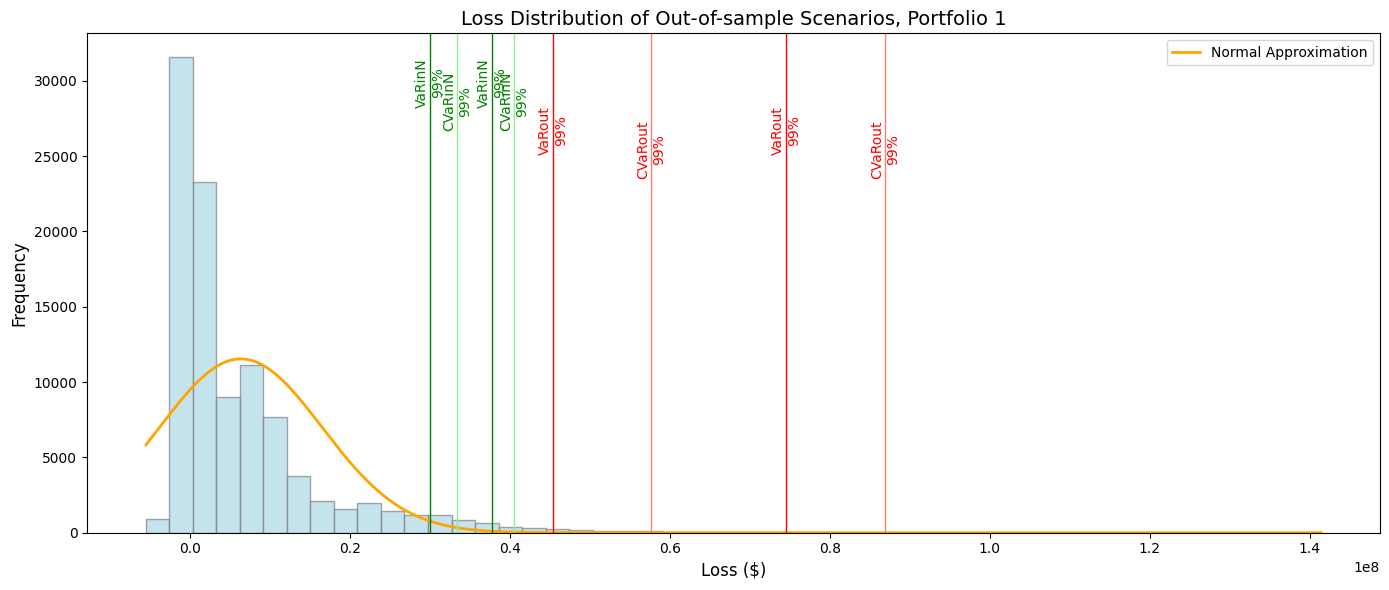

In [11]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# plot the bar chart
losses_p1 = portf_losses_out[:, 0]
mu_p1 = np.mean(losses_p1)
sigma_p1 = np.std(losses_p1, ddof=1)

fig, ax = plt.subplots(figsize=(14, 6))

count, bins, _ = ax.hist(losses_p1, bins=50, color='lightblue', edgecolor='grey', alpha=0.7)

x = np.linspace(min(losses_p1), max(losses_p1), 1000)
pdf = norm.pdf(x, mu_p1, sigma_p1)
pdf_scaled = pdf * (sum(count) * (bins[1] - bins[0]))
ax.plot(x, pdf_scaled, color='orange', linewidth=2, label='Normal Approximation')

alphas = [0.99, 0.999]
colors = ['green', 'red']
labels = ['VaRinN', 'CVaRinN', 'VaRout', 'CVaRout']

for i, alpha in enumerate(alphas):
    # Normal Approximation lines (green)
    ax.axvline(VaRinN[0, i], color='green', linestyle='-', linewidth=1)
    ax.text(VaRinN[0, i], max(count)*0.9, f'VaRinN\n{int(alpha*100)}%', color='green', rotation=90, ha='center')

    ax.axvline(CVaRinN[0, i], color='lightgreen', linestyle='-', linewidth=1)
    ax.text(CVaRinN[0, i], max(count)*0.85, f'CVaRinN\n{int(alpha*100)}%', color='green', rotation=90, ha='center')

    # Out-of-sample lines (red)
    ax.axvline(VaRout[0, i], color='red', linestyle='-', linewidth=1)
    ax.text(VaRout[0, i], max(count)*0.8, f'VaRout\n{int(alpha*100)}%', color='red', rotation=90, ha='center')

    ax.axvline(CVaRout[0, i], color='salmon', linestyle='-', linewidth=1)
    ax.text(CVaRout[0, i], max(count)*0.75, f'CVaRout\n{int(alpha*100)}%', color='red', rotation=90, ha='center')

ax.set_xlabel('Loss ($)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Loss Distribution of Out-of-sample Scenarios, Portfolio 1', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()


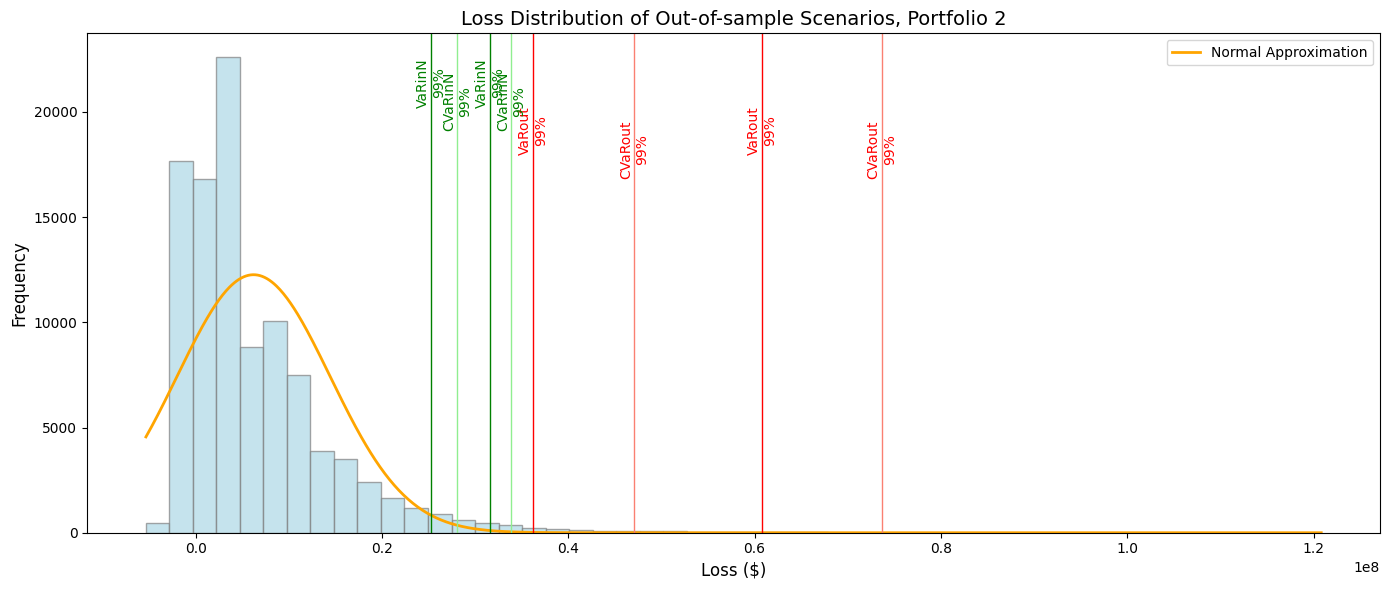

In [12]:
# portfolio 2 graph
losses_p2 = portf_losses_out[:, 1]
mu_p2 = np.mean(losses_p2)
sigma_p2 = np.std(losses_p2, ddof=1)

fig, ax = plt.subplots(figsize=(14, 6))

count, bins, _ = ax.hist(losses_p2, bins=50, color='lightblue', edgecolor='grey', alpha=0.7)

x = np.linspace(min(losses_p2), max(losses_p2), 1000)
pdf = norm.pdf(x, mu_p2, sigma_p2)
pdf_scaled = pdf * (sum(count) * (bins[1] - bins[0]))
ax.plot(x, pdf_scaled, color='orange', linewidth=2, label='Normal Approximation')

alphas = [0.99, 0.999]
for i, alpha in enumerate(alphas):
    # Green: Normal Approximation
    ax.axvline(VaRinN[1, i], color='green', linestyle='-', linewidth=1)
    ax.text(VaRinN[1, i], max(count)*0.9, f'VaRinN\n{int(alpha*100)}%', color='green', rotation=90, ha='center')

    ax.axvline(CVaRinN[1, i], color='lightgreen', linestyle='-', linewidth=1)
    ax.text(CVaRinN[1, i], max(count)*0.85, f'CVaRinN\n{int(alpha*100)}%', color='green', rotation=90, ha='center')

    # Red: Out-of-sample
    ax.axvline(VaRout[1, i], color='red', linestyle='-', linewidth=1)
    ax.text(VaRout[1, i], max(count)*0.8, f'VaRout\n{int(alpha*100)}%', color='red', rotation=90, ha='center')

    ax.axvline(CVaRout[1, i], color='salmon', linestyle='-', linewidth=1)
    ax.text(CVaRout[1, i], max(count)*0.75, f'CVaRout\n{int(alpha*100)}%', color='red', rotation=90, ha='center')

# Set labels and title
ax.set_xlabel('Loss ($)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Loss Distribution of Out-of-sample Scenarios, Portfolio 2', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()
